In [ ]:
"""
Statistical classification analysis
"""

import sys
from collections import Counter
from pathlib import Path
import pickle

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from wordcloud import WordCloud

try:
    ROOT = Path(__file__).resolve().parents[1]
except NameError:
    ROOT = Path.cwd().parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from config import DATA_PROCESSED, MODELS_DIR

/home/glaucia/miniconda3/envs/lab_npl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Settings
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

try:
    ROOT = Path(__file__).resolve().parents[1]
except NameError:
    ROOT = Path.cwd().parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [4]:
# Load the test dataframe
test_df = pd.read_csv(DATA_PROCESSED / "test.csv")

In [5]:
# Load model and vectorizer
clf = joblib.load(MODELS_DIR / "log_reg_tfidf.pkl")
with open(MODELS_DIR / "tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

X_test = tfidf_vectorizer.transform(test_df["clean_text"])
test_df["predicted_label"] = clf.predict(X_test)

📊 Classification Report:
              precision    recall  f1-score   support

          FR       0.87      0.95      0.90       787
         NFR       0.88      0.72      0.79       409

    accuracy                           0.87      1196
   macro avg       0.87      0.83      0.85      1196
weighted avg       0.87      0.87      0.87      1196



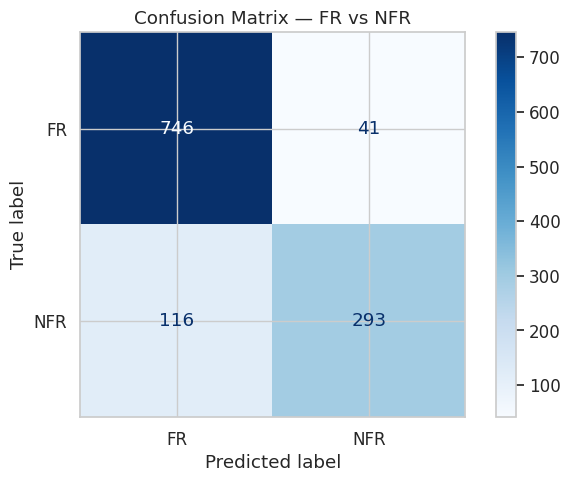

In [6]:
# Reports
print("📊 Classification Report:")
print(classification_report(test_df["label"], test_df["predicted_label"]))

cm = confusion_matrix(test_df["label"], test_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_df["label"]))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — FR vs NFR")
plt.show()

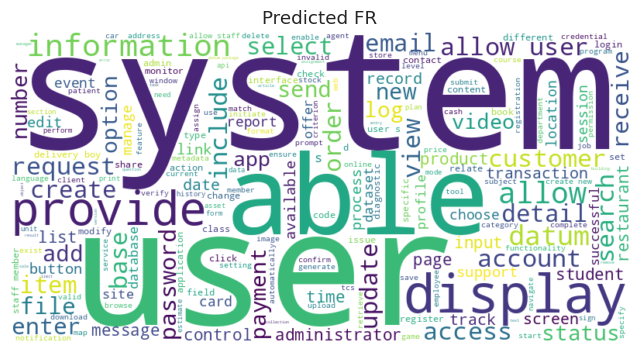

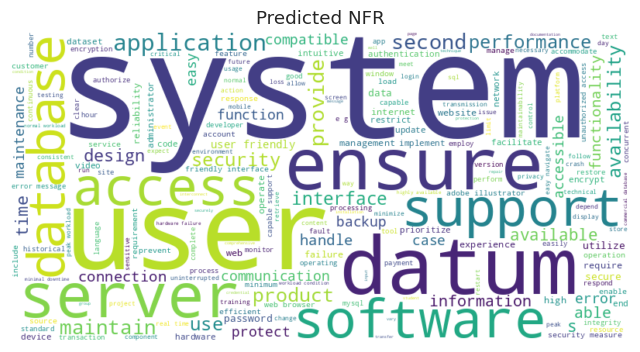

In [7]:
# WordCloud for each class
def plot_wordcloud(texts, title):
    text = " ".join(texts)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for label in test_df["predicted_label"].unique():
    plot_wordcloud(test_df[test_df["predicted_label"] == label]["clean_text"], f"Predicted {label}")


In [8]:
# Semantic similarity
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(test_df["clean_text"].tolist(), convert_to_tensor=True)
similarity_matrix = util.cos_sim(embeddings, embeddings)

for label in test_df["predicted_label"].unique():
    idx = test_df[test_df["predicted_label"] == label].index
    sims = similarity_matrix[np.ix_(idx, idx)]
    mean_sim = sims.mean().item()
    print(f"Mean semantic similarity within '{label}': {mean_sim:.3f}")

Mean semantic similarity within 'FR': 0.166
Mean semantic similarity within 'NFR': 0.190


In [ ]:
# Most frequent terms
def top_terms(texts, n=15):
    words = [w.lower() for t in texts for w in t.split() if w.lower() not in ENGLISH_STOP_WORDS]
    return pd.DataFrame(Counter(words).most_common(n), columns=["Term", "Count"])

for label in test_df["predicted_label"].unique():
    print(f"\n🔹 Top terms in {label}:")
    display(top_terms(test_df[test_df["predicted_label"] == label]["clean_text"]))



🔹 Top terms in FR:


,Term,Count
0,shall,808
1,user,442
2,able,271
3,allow,122
4,provide,81
5,display,78
6,information,66
7,datum,60
8,search,50
9,request,43



🔹 Top terms in NFR:


,Term,Count
0,shall,290
1,user,130
2,datum,50
3,ensure,40
4,support,33
5,access,32
6,database,30
7,server,29
8,software,28
9,application,24


In [10]:

# Summary
summary = {
    "samples": len(test_df),
    "distribution": test_df["predicted_label"].value_counts().to_dict(),
    "classification_report": classification_report(test_df["label"], test_df["predicted_label"], output_dict=True),
}

summary_df = pd.DataFrame(summary["classification_report"]).T
summary_path = DATA_PROCESSED / "validation_summary.csv"
summary_df.to_csv(summary_path)
print(f"\n Validation summary saved to {summary_path}")


 Validation summary saved to /home/glaucia/RequirementsNLP/data/processed/validation_summary.csv
